In [ ]:
import sys
if 'google.colab' in sys.modules:  # colab特有の処理_2回目以降
  # Google Driveのマウント
  from google.colab import drive
  drive.mount('/content/drive')

  # ライブラリのパス指定
  sys.path.append('/content/drive/MyDrive/Colab_Files/kaggle/commonlit/XX_modules')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# データセットをDriveから取得
!mkdir -p 'input'
!mkdir -p 'clrp-pre-trained'

!cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/00_input/commonlitreadabilityprize/' '/content/input'
!cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/97_pre_trained/clrp_pretrained_manish_epoch5/pre-trained-roberta/clrp_roberta_large/' '/content/clrp-pre-trained'

In [ ]:
from pathlib import Path

# input
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = Path('../input/commonlitreadabilityprize/')

elif 'google.colab' in sys.modules: # Colab環境
    DATA_DIR = Path('/content/input/commonlitreadabilityprize')

else:
    DATA_DIR = Path('../00_input/commonlitreadabilityprize/')

In [ ]:
from pathlib import Path

# tokenizer
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    TOKENIZER_DIR = '../input/roberta-transformers-pytorch/roberta-large'
elif 'google.colab' in sys.modules: # Colab環境
    TOKENIZER_DIR = '/content/clrp-pre-trained/clrp_roberta_large' # 仮で、毎回DLする想定のモデル名を指定。あとで変更予定。
else:
    TOKENIZER_DIR = 'roberta-large'

In [ ]:
from pathlib import Path

# pre-trained model
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    PRE_TRAINED_MODEL_DIR = '../input/roberta-transformers-pytorch/roberta-large'
elif 'google.colab' in sys.modules: # Colab環境
    PRE_TRAINED_MODEL_DIR = '/content/clrp-pre-trained/clrp_roberta_large' # 仮で、毎回DLする想定のモデル名を指定。あとで変更予定。
else:
    PRE_TRAINED_MODEL_DIR = 'roberta-large'

In [ ]:
UPLOAD_DIR = Path('/content/model')
EX_NO = '058-train-02'  # 実験番号などを入れる、folderのpathにする
USERID = 'calpis10000'

In [ ]:
import subprocess
import shlex

def gpuinfo():
    """
    Returns size of total GPU RAM and used GPU RAM.

    Parameters
    ----------
    None

    Returns
    -------
    info : dict
        Total GPU RAM in integer for key 'total_MiB'.
        Used GPU RAM in integer for key 'used_MiB'.
    """

    command = 'nvidia-smi -q -d MEMORY | sed -n "/FB Memory Usage/,/Free/p" | sed -e "1d" -e "4d" -e "s/ MiB//g" | cut -d ":" -f 2 | cut -c2-'
    commands = [shlex.split(part) for part in command.split(' | ')]
    for i, cmd in enumerate(commands):
        if i==0:
            res = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        else:
            res = subprocess.Popen(cmd, stdin=res.stdout, stdout=subprocess.PIPE)
    total, used = map(int, res.communicate()[0].decode('utf-8').strip().split('\n'))
    info = {'total_MiB':total, 'used_MiB':used}
    return info


# Overview
This nb is based on copy from https://www.kaggle.com/andretugan/lightweight-roberta-solution-in-pytorch .

Acknowledgments(from base nb): 
some ideas were taken from kernels by [Torch](https://www.kaggle.com/rhtsingh) and [Maunish](https://www.kaggle.com/maunish).

In [ ]:
import os
import math
import random
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW # optimizer
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup # scheduler
from pytorch_memlab import profile
import pytorch_memlab
from pytorch_memlab import MemReporter

from sklearn.model_selection import KFold, StratifiedKFold

import gc
gc.enable()

In [ ]:
NUM_FOLDS = 5 # K Fold
NUM_EPOCHS = 5 # Epochs
BATCH_SIZE = 12 # Batch Size
MAX_LEN = 248 # ベクトル長
EVAL_SCHEDULE = [(0.55, 64), (-1., 32)] # schedulerの何らかの設定？
ROBERTA_PATH = PRE_TRAINED_MODEL_DIR # roberta pre-trainedモデル(モデルとして指定)
TOKENIZER_PATH = TOKENIZER_DIR # roberta pre-trainedモデル(Tokenizerとして指定)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # cudaがなければcpuを使えばいいじゃない

In [ ]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True# cudnnによる最適化で結果が変わらないためのおまじない 

In [ ]:
# read train_df(kfold)
train_kf_df = pd.read_csv(DATA_DIR/"train_kfold.csv")

In [ ]:
# tokenizerを指定
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

# Dataset

In [ ]:
# 前処理用
import string
import re
import collections

# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text

def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter

# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
class TextDescriptionBlock(BaseBlock):
    """テキストに関する統計量を返す block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.param_prefix = f'col={column}'

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        # 前処理
        self.text = self.preprocess(input_df)
        self.counters = self.text.map(get_counter)

        # 変換処理
        _length = input_df[self.column].fillna('').map(lambda x: len(x) if x!='' else np.nan)
        _wrd_cnt = self.counters.map(lambda x: sum(x.values()))
        _wrd_nuniq = self.counters.map(lambda x: len(x))
        _wrd_mean = self.counters.map(lambda x: np.mean(list(x.values())))
        _wrd_max = self.counters.map(lambda x: np.max(list(x.values())))
        
        word_length = self.counters.map(lambda x: np.array([len(i) for i in x.keys()]))
        word_length_desc = word_length.map(lambda x: pd.Series(x.ravel()).describe())
        _word_length_desc_df = pd.DataFrame(word_length_desc.tolist()).iloc[:,1:]
        _word_length_desc_df = _word_length_desc_df.add_prefix('word_length_')
        
        out_df = pd.concat([_length, _wrd_cnt, _wrd_nuniq, _wrd_mean, _wrd_max], axis=1)
        out_df = out_df.reset_index().drop('index', axis='columns')
        out_df.columns = ['text_length', 'word_count', 'word_nunique', 'word_appearance_mean', 'word_appearance_max']
        out_df = pd.concat([out_df, _word_length_desc_df], axis=1).fillna(-1)
        return out_df.add_suffix(f'_{self.column}')

In [ ]:
class SentenceDescriptionBlock(BaseBlock):
    """テキスト(センテンス)に関する統計量を返す block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.param_prefix = f'col={column}'

    # 前処理
    def get_delimiter_feats(self, sentences: list):
      deli_df = pd.DataFrame([{'comma': i.count(','),
                                'colon': i.count(':'),
                                'semi-colon': i.count(';'),
                                'dash': i.count('—'),
                                'total': i.count(',') + i.count(':') + i.count(';') + i.count('—')
                                } for i in sentences])
      deli_disc = deli_df.describe().drop('count', axis='index')
      deli_disc.loc['sum', :] = deli_df.sum()
      deli_values = deli_disc.T.values.reshape(-1)
      col_list = []
      for col_ in deli_disc.columns:
        for idx_ in deli_disc.index:
          col_list.append(f'sentences_delim_{col_}_{idx_}')
      return pd.Series(data=deli_values, index=col_list)

    def transform(self, input_df):
        self.text = input_df.reset_index().drop('index', axis='columns')[self.column]
        self.sentences = self.text.map(lambda x: [i for i in x.split('.') if len(i) > 0])
        out_df = pd.DataFrame()

        # センテンス数
        out_df['sentences_cnt'] = self.sentences.map(lambda x: len(x)) 

        # センテンス長 × 各種統計量
        sentences_len = self.sentences.map(lambda x: [len(i) for i in x])
        sentences_len_df = pd.DataFrame(
                                        sentences_len.map(
                                            lambda x: pd.Series(x).describe().drop('count')
                                            ).tolist()
                                        ).add_prefix('sentence_length_')

        # センテンスの単語数(クリーニング)
        sentences_clean = self.sentences.map(lambda x: [text_prepare(i) for i in x])
        sentences_wrd_counter = sentences_clean.map(lambda x: [get_counter(i) for i in x])

        sentences_wrd_cnt_df = pd.DataFrame( # 単語数
                                        sentences_wrd_counter.map(
                                            lambda x: pd.Series([sum(i.values()) for i in x]).describe().drop('count')
                                            ).tolist()
                                        ).add_prefix('sentence_word_cnt_') 

        sentences_wrd_uniq_df = pd.DataFrame( # 単語のユニーク数
                                        sentences_wrd_counter.map(
                                            lambda x: pd.Series([len(i) for i in x]).describe().drop('count')
                                            ).tolist()
                                        ).add_prefix('sentence_word_uniq_')

        # 区切り文字の数を取得
        sentences_deli_df = self.sentences.apply(self.get_delimiter_feats)       
        
        out_df = pd.concat([out_df, 
                            sentences_len_df, 
                            sentences_wrd_cnt_df, 
                            sentences_wrd_uniq_df, 
                            sentences_deli_df], axis=1)
        
        out_df = out_df.reset_index().drop('index', axis='columns')
        return out_df.add_suffix(f'_{self.column}')

In [ ]:
# Dataset用のClass。
class LitDataset(Dataset):
    def __init__(self, df, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only # Testデータ用フラグ
        self.text = df.excerpt.tolist() # 分析対象カラムをlistにする。(分かち書きではなく、Seriesをlistへ変換するような処理)
        #self.text = [text.replace("\n", " ") for text in self.text] # 単語単位で分かち書きする場合
        #self.text_len = text_normalization(df.excerpt).map(lambda x: [0 if i >= len(x.split(' ')) else len(x.split(' ')[i]) for i in range(132)])
        desc_block = TextDescriptionBlock('excerpt')
        sent_block = SentenceDescriptionBlock('excerpt')
        text_desc = desc_block.fit(self.df)
        text_sent = sent_block.fit(self.df)
        self.text_feats = pd.concat([text_desc, text_sent], axis='columns')

        if not self.inference_only:
            self.target = torch.tensor(df.target.values, dtype=torch.float32) # trainのみ、targetをtensorに変換
            self.standard_error = torch.tensor(df.standard_error.values, dtype=torch.float32) 

        self.encoded = tokenizer.batch_encode_plus( # textをtokenize
            self.text,
            padding = 'max_length',            
            max_length = MAX_LEN,
            truncation = True, # 最大長を超える文字は切り捨て
            return_attention_mask=True
        )        
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index): # 変換結果を返す
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        #input_len = torch.tensor(self.text_len.iloc[index], dtype=torch.float32)
        input_desc = torch.tensor(self.text_feats.values[index], dtype=torch.float32)

        if self.inference_only:
            return (input_ids, attention_mask, input_desc)            
        else:
            target = self.target[index]
            standard_error = self.standard_error[index]
            return (input_ids, attention_mask, input_desc, target, standard_error)

In [ ]:
# 検証
#litds = LitDataset(train_kf_df.loc[train_indices])
#litds[0][2].shape

In [ ]:
# 検証
#litds = LitDataset(train_kf_df)
#litds[0][2].shape

# Model
The model is inspired by the one from [Maunish](https://www.kaggle.com/maunish/clrp-roberta-svm).

In [ ]:
class LitModel(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(ROBERTA_PATH) # pretrainedからconfigを読み込み
        config.update({"output_hidden_states":True, # config更新: embedding層を抽出
                       "hidden_dropout_prob": 0.0, # config更新: dropoutしない
                       "layer_norm_eps": 1e-7}) # config更新: layer normalizationのepsilon                      
        
        self.roberta = AutoModel.from_pretrained(ROBERTA_PATH, config=config)
            
        self.attention = nn.Sequential(# attentionレイヤー            
            nn.Linear(config.hidden_size, 512),      
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )

        self.numeric_feats = nn.Sequential(
            nn.Linear(74, 74),
            nn.BatchNorm1d(74),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(74, 74),
            nn.BatchNorm1d(74),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.regressor = nn.Sequential( # target、stderror                  
            nn.Linear(config.hidden_size + 74, 2),
        )

        #self.bin_class = nn.Sequential( # target_sign
        #    nn.Linear(config.hidden_size + 64, 1),
        #    nn.Dropout(p=0.2),
        #    nn.Sigmoid()                       
        #)


    def forward(self, input_ids, attention_mask, input_desc):
        roberta_output = self.roberta(input_ids=input_ids, # robertaに入力データを流し、出力としてrobertaモデル(layerの複合体)を得る
                                      attention_mask=attention_mask)     
        # attention_pooling
        last_hidden_state = roberta_output.hidden_states[-1] # robertaモデルの最後のlayerを得る
        weights = self.attention(last_hidden_state) # robertaの最後のlayerをattentionへ入力し、出力として重みを得る                
        context_vector = torch.sum(weights * last_hidden_state, dim=1) # 重み×最後の層を足し合わせて文書ベクトルとする。
        # word_length_conv1d
        #input_chnl = input_len.unsqueeze(1)
        #conv1_layers = self.conv1_layers(input_chnl)
        #conv1_layers_v = conv1_layers.view(conv1_layers.size(0),-1)

        # numeric_feats
        numeric_feats = self.numeric_feats(input_desc)

        # https://www.kaggle.com/rhtsingh/utilizing-transformer-representations-efficiently
        # last_hidden_state = roberta_output[0]
        # input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        # sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        # sum_mask = input_mask_expanded.sum(1)
        # sum_mask = torch.clamp(sum_mask, min=1e-9)
        # mean_embeddings = sum_embeddings / sum_mask
        cat_layers = torch.cat([context_vector, numeric_feats], dim=1)
        return self.regressor(cat_layers)
        
        # Now we reduce the context vector to the prediction score.
        #return self.regressor(mean_embeddings) # 文書ベクトルを線形層に入力し、targetを出力する

In [ ]:
def eval_mse(model, data_loader):
    """Evaluates the mean squared error of the |model| on |data_loader|"""
    model.eval() # evalモードを選択。Batch Normとかdropoutをしなくなる           
    mse_mean_sum = 0
    mse_std_sum = 0

    with torch.no_grad(): # 勾配の計算をしない(予測のみ行う)
        for batch_num, (input_ids, attention_mask, input_feats, target, standard_error) in enumerate(data_loader): # data_loaderからinput, attentin_mask, targetをbatchごとに取り出す
            input_ids = input_ids.to(DEVICE)   
            attention_mask = attention_mask.to(DEVICE)  
            input_feats = input_feats.to(DEVICE) 
            target = target.to(DEVICE)
            standard_error = standard_error.to(DEVICE)
            
            output = model(input_ids, attention_mask, input_feats) # 取得した値をモデルへ入力し、出力として予測値を得る。

            mse_mean_sum += nn.MSELoss(reduction="sum")(output[:,0].flatten(), target).item() # 誤差の合計を得る(Batchごとに計算した誤差を足し上げる)
            mse_std_sum += nn.MSELoss(reduction="sum")(output[:,1].flatten(), standard_error).item() # 誤差の合計を得る(Batchごとに計算した誤差を足し上げる)


    del input_ids
    del attention_mask

    mse_mean_result = mse_mean_sum / len(data_loader.dataset)
    mse_std_result = mse_std_sum / len(data_loader.dataset)

    return mse_mean_result, mse_std_result

In [ ]:
# 推論結果を返す
def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval() # evalモード(dropout, batch_normしない)

    result = np.zeros(len(data_loader.dataset)) # 結果をdataset長のzero配列として用意
    index = 0
    
    with torch.no_grad(): # 勾配の計算をしないblock(inputすると、現状の重みによる推論結果を返す)
        for batch_num, (input_ids, attention_mask, input_feats) in enumerate(data_loader): # data_loaderからbatchごとにinputを得る
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            input_feats = input_feats.to(DEVICE)
                        
            output = model(input_ids, attention_mask, input_feats) # modelにinputを入力し、予測結果を得る。
            output_target = output[:,0]

            result[index : index + output_target.shape[0]] = output_target.flatten().to("cpu") # result[index ~ predの長さ]へ、予測結果を格納
            index += output_target.shape[0] # indexを更新

    return result # 全batchで推論が終わったら、結果を返す

In [ ]:
# 学習
def train(model, # モデル
          model_path, # モデルのアウトプット先
          train_loader, # train-setのdata_loader
          val_loader, # valid-setのdata_loader
          optimizer, # optimizer
          scheduler=None, # scheduler, デフォルトはNone
          num_epochs=NUM_EPOCHS # epoch数、notebook冒頭で指定した値
         ):    
    
    best_val_rmse = None
    best_val_sign_bce = None
    best_epoch = 0
    step = 0
    last_eval_step = 0
    eval_period = EVAL_SCHEDULE[0][1] # eval期間(って何？) 冒頭で決めたEVAL_SCHEDULEの最初のtupleの[1]を取得

    start = time.time() # 時間計測用

    for epoch in range(num_epochs): # 指定したEpoch数だけ繰り返し
        val_rmse = None         

        for batch_num, (input_ids, attention_mask, input_feats, target, standard_error) in enumerate(train_loader): # train_loaderからinput, targetを取得
            input_ids = input_ids.to(DEVICE) # inputをDEVICEへ突っ込む
            attention_mask = attention_mask.to(DEVICE)   
            input_feats = input_feats.to(DEVICE)
            target = target.to(DEVICE)
            standard_error = standard_error.to(DEVICE)

            optimizer.zero_grad() # 勾配を初期化            
            model.train() # 学習モード開始

            # https://www.kaggle.com/c/commonlitreadabilityprize/discussion/239421
            output = model(input_ids, attention_mask, input_feats) # input,attention_maskを入力し、予測結果を得る
            p = torch.distributions.Normal(output[:,0], torch.sqrt(output[:,1]**2))
            q = torch.distributions.Normal(target, standard_error)
            kl_vector = torch.distributions.kl_divergence(p, q)

            loss = kl_vector.mean()

            loss.backward() 
            optimizer.step() # 重みを更新する

            if scheduler:
                scheduler.step() # schedulerが与えられた場合は、schedulerの学習率更新
            
            if step >= last_eval_step + eval_period: # batchを回すごとにstepを増やしていって、「前回evalしたstep + eval_period(16)」を超えたら実行。
                print(gpuinfo())
                # Evaluate the model on val_loader.
                elapsed_seconds = time.time() - start # 経過時間
                num_steps = step - last_eval_step # 経過ステップ数
                print(f"\n{num_steps} steps took {elapsed_seconds:0.3} seconds")
                last_eval_step = step # 前回stepの更新
                
                # valid-setによるrmse計算
                train_kldiv = loss
                
                val_mse_mean, val_mse_std = eval_mse(model, val_loader)
                val_rmse_mean = math.sqrt(val_mse_mean)                            
                val_rmse_std = math.sqrt(val_mse_std)                            

                print(f"Epoch: {epoch} batch_num: {batch_num}")
                print(f"train_kldiv: {train_kldiv:0.4}"
                      )
                print(f"val_rmse_mean: {val_rmse_mean:0.4}",
                      f"val_rmse_std: {val_rmse_std:0.4}"
                      )

                for rmse, period in EVAL_SCHEDULE: # eval_periodをvalid-rmseで切り替える処理
                    if val_rmse_mean >= rmse: # valid rmseをEVAL_SCHEDULEと比較し、0項 > valid rmseとなるまで回す : EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
                        eval_period = period # eval_periodを更新
                        break                               

                if not best_val_rmse or val_rmse_mean < best_val_rmse: # 初回(best_val_rmse==None), またはbest_val_rmseを更新したらモデルを保存する
                    best_val_rmse = val_rmse_mean
                    best_epoch = epoch
                    torch.save(model.state_dict(), model_path) # 最高の自分を保存
                    print(f"New best_val_rmse: {best_val_rmse:0.4}")
                else:       
                    print(f"Still best_val_rmse: {best_val_rmse:0.4}", # 更新されない場合は、元のスコアを表示
                          f"(from epoch {best_epoch})")      

                start = time.time()
            
            # batchごとにメモリ解放
            del input_ids
            del attention_mask
            torch.cuda.empty_cache()                                            
            step += 1
    
    return best_val_rmse

In [ ]:
# optimizerの作成
def create_optimizer(model):
    parameters = []

    named_parameters = list(model.named_parameters()) # モデルパラメータの取得
    roberta_parameters = list(model.roberta.named_parameters())[:-2] # パラメータをroberta用、attention用、regressor用に格納。(直接引っ張ってくる形式に変更)

    attention_parameters = list(model.attention.named_parameters())
    attention_group = [{'params': params, 'lr': 2e-5} for (name, params) in attention_parameters] # attention用パラメータをリストとして取得
    parameters += attention_group

    regressor_parameters = list(model.regressor.named_parameters())
    regressor_group = [{'params': params, 'lr': 2e-5} for (name, params) in regressor_parameters] # reg用パラメータをリストとして取得
    parameters += regressor_group

    numeric_feats_parameters = list(model.numeric_feats.named_parameters())
    numeric_feats_group = [{'params': params, 'lr': 2e-5} for (name, params) in numeric_feats_parameters] # reg用パラメータをリストとして取得
    parameters += numeric_feats_group

    for layer_num, (name, params) in enumerate(roberta_parameters): # レイヤーごとにname, paramsを取得していろんな処理
        weight_decay = 0.0 if "bias" in name else 0.01

        lr = 8e-6

        if layer_num >= 69:        
            lr = 2e-5

        if layer_num >= 133:
            lr = 4e-5

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return AdamW(parameters) # 最終的に、AdamWにパラメータを入力する。


In [ ]:
def train_and_save_model(train_indices, val_indices, model_path):
    train_dataset = LitDataset(train_kf_df.loc[train_indices]) # train, validのDataset
    val_dataset = LitDataset(train_kf_df.loc[val_indices])
        
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              drop_last=True, shuffle=True, num_workers=2) # train, validのDataLoader
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            drop_last=False, shuffle=False, num_workers=2)    

    model = LitModel().to(DEVICE) # modelをDEVICEへぶち込む
    optimizer = create_optimizer(model) # optimizerをモデルから作成
    scheduler = get_cosine_schedule_with_warmup( # schedulerを作成
        optimizer,
        num_training_steps=NUM_EPOCHS * len(train_loader),
        num_warmup_steps=50)    
    rmse = train(model, model_path, train_loader, val_loader, optimizer, scheduler=scheduler)

    del train_dataset
    del val_dataset
    del train_loader
    del val_loader
    del model
    del optimizer
    del scheduler
    gc.collect() 
    torch.cuda.empty_cache()
    return rmse

In [ ]:
# 実行処理。 KFold & 学習
SEED = 1000
list_val_rmse = []

for fold in sorted(train_kf_df['kfold'].unique()):
    print(f"\nFold {fold + 1}/{NUM_FOLDS}")
    print(gpuinfo())
    model_path = f"model_{fold + 1}.pth" # model_fold数_.pth
    set_random_seed(SEED + fold) # SEEDはfold別に変わるようにする

    train_indices = (train_kf_df['kfold'] != fold)
    val_indices = (train_kf_df['kfold'] == fold)
    list_val_rmse.append(train_and_save_model(train_indices, val_indices, model_path))
    print("\nPerformance estimates:")
    print(list_val_rmse)
    print("Mean:", np.array(list_val_rmse).mean())
    print(gpuinfo())


Fold 1/5
{'total_MiB': 16280, 'used_MiB': 2}


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 83.7 seconds
Epoch: 0 batch_num: 64
train_kldiv: 0.5963
val_rmse_mean: 0.7148 val_rmse_std: 1.004
New best_val_rmse: 0.7148
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.2 seconds
Epoch: 0 batch_num: 128
train_kldiv: 0.5839
val_rmse_mean: 0.661 val_rmse_std: 1.01
New best_val_rmse: 0.661
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.4 seconds
Epoch: 1 batch_num: 4
train_kldiv: 0.4006
val_rmse_mean: 0.5594 val_rmse_std: 1.02
New best_val_rmse: 0.5594
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.3 seconds
Epoch: 1 batch_num: 68
train_kldiv: 0.4175
val_rmse_mean: 0.5601 val_rmse_std: 0.9534
Still best_val_rmse: 0.5594 (from epoch 1)
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.2 seconds
Epoch: 1 batch_num: 132
train_kldiv: 0.3077
val_rmse_mean: 0.5178 val_rmse_std: 0.9932
New best_val_rmse: 0.5178
{'total_MiB': 16280, 'used_MiB': 15093}

32 steps took 41.4 seconds
Epoch: 1 batch_num: 1

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 83.0 seconds
Epoch: 0 batch_num: 64
train_kldiv: 1.006
val_rmse_mean: 0.6825 val_rmse_std: 0.1145
New best_val_rmse: 0.6825
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.1 seconds
Epoch: 0 batch_num: 128
train_kldiv: 0.4322
val_rmse_mean: 0.5805 val_rmse_std: 0.1052
New best_val_rmse: 0.5805
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.2 seconds
Epoch: 1 batch_num: 4
train_kldiv: 0.5034
val_rmse_mean: 0.5493 val_rmse_std: 0.06945
New best_val_rmse: 0.5493
{'total_MiB': 16280, 'used_MiB': 15093}

32 steps took 41.3 seconds
Epoch: 1 batch_num: 36
train_kldiv: 0.5642
val_rmse_mean: 0.5774 val_rmse_std: 0.06919
Still best_val_rmse: 0.5493 (from epoch 1)
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.0 seconds
Epoch: 1 batch_num: 100
train_kldiv: 0.8354
val_rmse_mean: 0.5198 val_rmse_std: 0.1033
New best_val_rmse: 0.5198
{'total_MiB': 16280, 'used_MiB': 15093}

32 steps took 41.3 seconds
Epoch: 1 batc

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 83.3 seconds
Epoch: 0 batch_num: 64
train_kldiv: 1.299
val_rmse_mean: 0.689 val_rmse_std: 0.9287
New best_val_rmse: 0.689
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.1 seconds
Epoch: 0 batch_num: 128
train_kldiv: 0.6615
val_rmse_mean: 0.6695 val_rmse_std: 0.9992
New best_val_rmse: 0.6695
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.3 seconds
Epoch: 1 batch_num: 4
train_kldiv: 0.5136
val_rmse_mean: 0.5414 val_rmse_std: 0.9971
New best_val_rmse: 0.5414
{'total_MiB': 16280, 'used_MiB': 15093}

32 steps took 41.4 seconds
Epoch: 1 batch_num: 36
train_kldiv: 0.1943
val_rmse_mean: 0.5226 val_rmse_std: 0.9832
New best_val_rmse: 0.5226
{'total_MiB': 16280, 'used_MiB': 15093}

32 steps took 41.4 seconds
Epoch: 1 batch_num: 68
train_kldiv: 0.4642
val_rmse_mean: 0.5512 val_rmse_std: 0.965
Still best_val_rmse: 0.5226 (from epoch 1)
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.1 seconds
Epoch: 1 batch_num:

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 83.4 seconds
Epoch: 0 batch_num: 64
train_kldiv: 0.6181
val_rmse_mean: 0.7383 val_rmse_std: 1.099
New best_val_rmse: 0.7383
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.3 seconds
Epoch: 0 batch_num: 128
train_kldiv: 0.7273
val_rmse_mean: 0.5922 val_rmse_std: 1.001
New best_val_rmse: 0.5922
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.5 seconds
Epoch: 1 batch_num: 4
train_kldiv: 0.5208
val_rmse_mean: 0.6875 val_rmse_std: 1.019
Still best_val_rmse: 0.5922 (from epoch 0)
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.2 seconds
Epoch: 1 batch_num: 68
train_kldiv: 0.4424
val_rmse_mean: 0.5242 val_rmse_std: 0.9928
New best_val_rmse: 0.5242
{'total_MiB': 16280, 'used_MiB': 15093}

32 steps took 41.4 seconds
Epoch: 1 batch_num: 100
train_kldiv: 0.6418
val_rmse_mean: 0.5486 val_rmse_std: 1.027
Still best_val_rmse: 0.5242 (from epoch 1)
{'total_MiB': 16280, 'used_MiB': 15093}

32 steps took 41.4 seconds
E

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 83.3 seconds
Epoch: 0 batch_num: 64
train_kldiv: 1.902
val_rmse_mean: 0.6224 val_rmse_std: 0.07399
New best_val_rmse: 0.6224
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.3 seconds
Epoch: 0 batch_num: 128
train_kldiv: 0.9011
val_rmse_mean: 0.5684 val_rmse_std: 0.07525
New best_val_rmse: 0.5684
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.5 seconds
Epoch: 1 batch_num: 4
train_kldiv: 0.3445
val_rmse_mean: 0.5279 val_rmse_std: 0.0672
New best_val_rmse: 0.5279
{'total_MiB': 16280, 'used_MiB': 15093}

32 steps took 41.5 seconds
Epoch: 1 batch_num: 36
train_kldiv: 0.2316
val_rmse_mean: 0.5588 val_rmse_std: 0.06343
Still best_val_rmse: 0.5279 (from epoch 1)
{'total_MiB': 16280, 'used_MiB': 15093}

64 steps took 82.3 seconds
Epoch: 1 batch_num: 100
train_kldiv: 0.3927
val_rmse_mean: 0.4955 val_rmse_std: 0.05692
New best_val_rmse: 0.4955
{'total_MiB': 16280, 'used_MiB': 15093}

32 steps took 41.5 seconds
Epoch: 1 ba

In [ ]:
"""desc_block = TextDescriptionBlock('excerpt')
desc_feats = desc_block.fit(train_kf_df.loc[train_indices])
desc_block_src = TextDescriptionBlock('excerpt')
desc_feats_src = desc_block_src.fit(train_kf_df.head(10))"""

"desc_block = TextDescriptionBlock('excerpt')\ndesc_feats = desc_block.fit(train_kf_df.loc[train_indices])\ndesc_block_src = TextDescriptionBlock('excerpt')\ndesc_feats_src = desc_block_src.fit(train_kf_df.head(10))"

In [ ]:
"""train_dataset = LitDataset(train_kf_df.loc[train_indices]) # train, validのDataset
val_dataset = LitDataset(train_kf_df.loc[val_indices])
    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          drop_last=True, shuffle=True, num_workers=2) # train, validのDataLoader
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        drop_last=False, shuffle=False, num_workers=2)    
"""

'train_dataset = LitDataset(train_kf_df.loc[train_indices]) # train, validのDataset\nval_dataset = LitDataset(train_kf_df.loc[val_indices])\n    \ntrain_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,\n                          drop_last=True, shuffle=True, num_workers=2) # train, validのDataLoader\nval_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,\n                        drop_last=False, shuffle=False, num_workers=2)    \n'

In [ ]:
print(list_val_rmse)

[0.48516161186118684, 0.4691287610685, 0.47370595559878237, 0.4762812679965918, 0.47122576231820734]


In [ ]:
#rep = MemReporter(model)
#rep.report()

In [ ]:
#rep = MemReporter(model.roberta)
#rep.report()

In [ ]:
#gpuinfo()

In [ ]:
#del model
#del optimizer 
#del train_loader
#del val_loader
#del scheduler 
#del list_val_rmse
#del train_indices
#del val_indices
#del tokenizer
#torch.cuda.empty_cache()
#gpuinfo()

# upload models

In [ ]:
%cd
!mkdir .kaggle
!mkdir /content/model
!cp /content/drive/MyDrive/Colab_Files/kaggle-api/kaggle.json .kaggle/

!cp -r /content/model_1.pth /content/model/model_1.pth
!cp -r /content/model_2.pth /content/model/model_2.pth
!cp -r /content/model_3.pth /content/model/model_3.pth
!cp -r /content/model_4.pth /content/model/model_4.pth
!cp -r /content/model_5.pth /content/model/model_5.pth

/root


In [ ]:
import shutil
model_path_out = Path('/content/model/')
dir_ = f'/content/drive/MyDrive/Colab_Files/kaggle/commonlit/98_model_inf/{EX_NO}'
!mkdir {dir_}
tgdir = Path(dir_)

for file_ in list(model_path_out.iterdir()):
  shutil.copy(file_, tgdir)

In [ ]:
def dataset_upload():
    import json
    from kaggle.api.kaggle_api_extended import KaggleApi

    id = f'{USERID}/{EX_NO}'
    print(id)

    dataset_metadata = {}
    dataset_metadata['id'] = id
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = f'{EX_NO}'

    with open(UPLOAD_DIR / 'dataset-metadata.json', 'w') as f:
        json.dump(dataset_metadata, f, indent=4)

    api = KaggleApi()
    api.authenticate()

    # データセットがない場合
    if f'{USERID}/{EX_NO}' not in [str(d) for d in api.dataset_list(user=USERID, search=f'"{EX_NO}"')]:
        api.dataset_create_new(folder=UPLOAD_DIR,
                               convert_to_csv=False,
                               dir_mode='skip')
    # データセットがある場合
    else:
        api.dataset_create_version(folder=UPLOAD_DIR,
                                   version_notes='update',
                                   convert_to_csv=False,
                                   delete_old_versions=True,
                                   dir_mode='skip')
dataset_upload()



calpis10000/058-train-02


  0%|          | 0.00/1.33G [00:00<?, ?B/s]

Starting upload for file model_4.pth


100%|██████████| 1.33G/1.33G [00:26<00:00, 53.6MB/s]
  0%|          | 0.00/1.33G [00:00<?, ?B/s]

Upload successful: model_4.pth (1GB)
Starting upload for file model_1.pth


100%|██████████| 1.33G/1.33G [00:26<00:00, 53.1MB/s]
  0%|          | 0.00/1.33G [00:00<?, ?B/s]

Upload successful: model_1.pth (1GB)
Starting upload for file model_5.pth


100%|██████████| 1.33G/1.33G [00:26<00:00, 54.3MB/s]
  0%|          | 0.00/1.33G [00:00<?, ?B/s]

Upload successful: model_5.pth (1GB)
Starting upload for file model_3.pth


100%|██████████| 1.33G/1.33G [00:26<00:00, 53.9MB/s]
  0%|          | 0.00/1.33G [00:00<?, ?B/s]

Upload successful: model_3.pth (1GB)
Starting upload for file model_2.pth


100%|██████████| 1.33G/1.33G [00:26<00:00, 53.1MB/s]


Upload successful: model_2.pth (1GB)


In [ ]:
# validation再実行_予測結果取得
all_predictions = np.zeros(len(train_kf_df)) # 推論結果について、「fold　× 推論df」のzero行列で枠を作る

for fold_ in sorted(train_kf_df['kfold'].unique()):
    model_path = UPLOAD_DIR/f"model_{fold_ + 1}.pth" # 対応するモデルを読む
    print(f"\nUsing {model_path}")

    val_idx = train_kf_df['kfold'] == fold_
    val_df = train_kf_df[val_idx]
    val_dataset = LitDataset(val_df, inference_only=True) # TestのDataset(何で、もう一回作るのだろう？)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          drop_last=False, shuffle=False, num_workers=2) # TestのDataLoader

    model = LitModel()
    model.load_state_dict(torch.load(model_path))    # 対応するモデルから、重みを読み込む
    model.to(DEVICE) # モデルをDEVICEへぶち込む

    all_predictions[val_idx] = predict(model, val_loader) # 推論結果行列の対象列に、推論結果を入力(以後、繰り返し)

    del model
    gc.collect()



Using /content/model/model_1.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


Using /content/model/model_2.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


Using /content/model/model_3.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


Using /content/model/model_4.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi


Using /content/model/model_5.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

In [ ]:
from sklearn.metrics import mean_squared_error
import math
np.sqrt(mean_squared_error(train_kf_df.target.values, all_predictions))

0.4751343137650183

In [ ]:
train_kf_df['pred'] = all_predictions
fold = 1
tg_true = train_kf_df[train_kf_df['kfold']==fold]['target'].values
tg_pred = train_kf_df[train_kf_df['kfold']==fold]['pred'].values
np.sqrt(mean_squared_error(tg_true, tg_pred))

0.46912876169040524

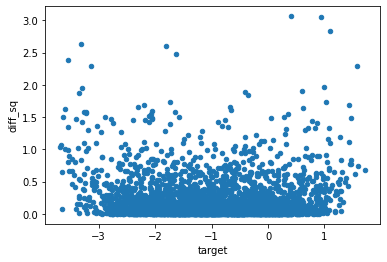

In [ ]:
train_kf_df['pred'] = all_predictions
train_kf_df['diff_sq'] = (train_kf_df['target'] - train_kf_df['pred'])**2
train_kf_df.plot(kind='scatter', x='target', y='diff_sq')

In [ ]:
# 二乗誤差が2.0を超える列
thr_ = 2.0 
train_kf_df[train_kf_df['diff_sq'] > thr_]

,id,url_legal,license,excerpt,target,standard_error,kfold,bins_tg,bins_std,bins,pred,diff_sq
141,bcd734621,NaN,NaN,Midas was enjoying himself in his treasure-roo...,0.943021,0.537713,0,10,5,105,-0.802351,3.046322
990,afeb324bd,NaN,NaN,"On the morning of the 20th of March, a long se...",0.401053,0.481889,0,9,2,92,-1.348900,3.062335
1314,85b41606e,NaN,NaN,"As soon as the plate is dry, a positive cliché...",-3.543987,0.609348,3,0,9,9,-2.000015,2.383851
1412,8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,"Every day, Emeka's father took him to school i...",1.583847,0.624776,1,11,10,1110,0.071463,2.287303
1628,4cf4a2fa3,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,"Although anyone, from kids to the elderly, can...",-1.802185,0.518239,1,4,4,44,-0.191276,2.595029
1944,04ade0eb2,NaN,NaN,"While I was hailing the brig, I spied a tract ...",-3.315282,0.544735,2,0,6,6,-1.693418,2.630444
2124,76f92b721,NaN,NaN,"The biggest desert in the world is in Africa, ...",1.103341,0.553751,2,10,6,106,-0.578314,2.827965
2277,7c732b8bb,https://en.wikipedia.org/wiki/Environmental_sc...,CC BY-SA 3.0,Environmental science is an interdisciplinary ...,-3.137143,0.555843,0,1,6,16,-1.622923,2.292862
2611,034bfda3f,https://www.commonlit.org/texts/everyday-life-...,CC BY-NC-SA 2.0,Even the clothes we wear every day are scrupul...,-1.624428,0.484176,1,4,3,43,-0.050776,2.476382


In [ ]:
# 二乗誤差が2.0を超える文章
thr_ = 2.0 
tmp_df = train_kf_df[train_kf_df['diff_sq'] > thr_].copy()
for i in tmp_df.index:
  print(tmp_df.loc[i].target)
  #print(tmp_df.loc[i].standard_error)
  print(tmp_df.loc[i].pred)
  print(tmp_df.loc[i].excerpt)
  print('--------------------------')

0.943020903
-0.8023508191108704
Midas was enjoying himself in his treasure-room, one day, as usual, when he perceived a shadow fall over the heaps of gold; and, looking suddenly up, what should he behold but the figure of a stranger, standing in the bright and narrow sunbeam! It was a young man, with a cheerful and ruddy face. Whether it was that the imagination of King Midas threw a yellow tinge over everything, or whatever the cause might be, he could not help fancying that the smile with which the stranger regarded him had a kind of golden radiance in it. Certainly, although his figure intercepted the sunshine, there was now a brighter gleam upon all the piled-up treasures than before. Even the remotest corners had their share of it, and were lighted up, when the stranger smiled, as with tips of flame and sparkles of fire.
--------------------------
0.401052549
-1.3489004373550415
On the morning of the 20th of March, a long series of earthquakes spread alarm throughout all the citie